# Precipitation Forecast Task

Download this zip file, containing historical daily precipitation maps for the continental United States (excluding the state of Alaska). Your task is to train a model to take any number (determined by you) of daily precipitation maps as input, and generate precipitation forecast maps for one week (7 days) into the future.

To complete this task, you may select any model architecture you deem appropriate. Include your python3 training and evaluation code, as well as a test application with a basic user interface as part of your submission. The interface does not have to include any graphical components, but must accept a list of input images, and save the resulting forecast maps as images to the current directory. Also include the generated forecast maps for one week after the last available date in the data, as on the date of your submission (the data is updated daily, but available information may lag by a few days).

Write a report detailing your approach, and address (and justify as necessary) at least the following points in any order:



### Problem Definition Framework

The steps I apply in solving the task is by understanding the problem. The challenge is to train a model that take images of daily precipitation maps as input, and generate precipitation forecast maps for one week (7 days) into the future. According to Tom Mitchell, machine learning is a computer program that learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E. Therefore, this program

### Environment

This task assumes we have a Python SciPy environment installed as well as Python 3. The task assumes we also have Keras v2.0 or higher installed with either the TensorFlow or Theano backend.

In [1]:
# Import librariesfrom PIL import Image
import numpy as np
import glob
import os,cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.layers import Conv2D
from keras.layers import TimeDistributed


/Users/boratonaj/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/boratonaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Preparation and Model Evaluation

This section of the task describes data preparation and model evaluation used in this tutorial

#### Data Split

We will split the precipitation images dataset into two parts: a training and a test set.

The first few datasets will be taken for the training dataset and the remaining will be used for the test set.

Models will be developed using the training dataset and will make predictions on the test dataset.

(2389, 320, 400)
(2389, 1, 320, 400)


/Users/boratonaj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 320, 4..., padding="same")`
/Users/boratonaj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/Users/boratonaj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/Users/boratonaj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 320, 400)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 320, 400)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 318, 398)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 318, 398)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 159, 199)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 159, 199)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 157, 197)      18496     
__________

ValueError: Error when checking : expected conv2d_1_input to have 4 dimensions, but got array with shape (1, 1, 0)

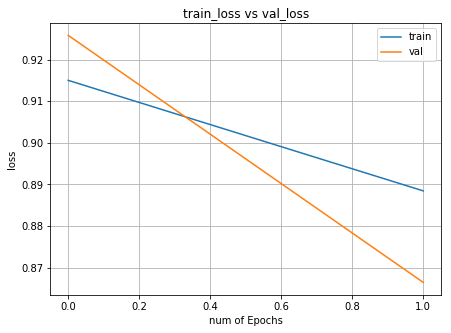

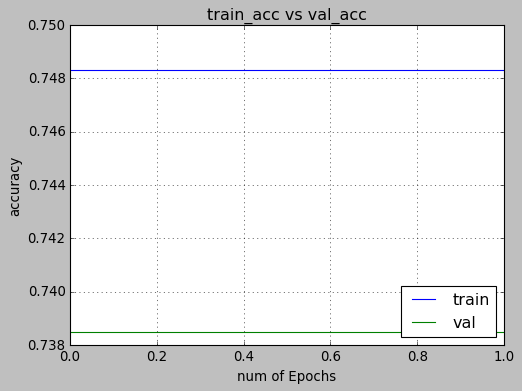

In [2]:
from PIL import Image
import numpy as np
import glob
# Import libraries
import os,cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.layers import Conv2D
from keras.layers import TimeDistributed
# generate the next frame in the sequence

# loading directory to generate the next frame in the sequence project
def load_images(img_path):
    images= glob.glob(img_path)
    img_data = np.array([np.array(Image.open(fname)) for fname in images])
    img_data.dump('file.npy')
    img_data = np.load('file.npy')
    return img_data

filelist = 'dataset/*.gif'
img_data = load_images(filelist)
#print(img_data)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)
img_rows=128
img_cols=128
num_channel=1
num_epoch=2

# Define the number of classes
num_classes = 4

if num_channel==1:
	if K.image_dim_ordering()=='th':
		img_data= np.expand_dims(img_data, axis=1) 
		print (img_data.shape)
	else:
		img_data= np.expand_dims(img_data, axis=4) 
		print (img_data.shape)
		
else:
	if K.image_dim_ordering()=='th':
		img_data=np.rollaxis(img_data,3,1)
		print (img_data.shape)
		
#%%

USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
# using sklearn for preprocessing
    from sklearn import preprocessing
    # To resize an image, 
    def image_to_feature_vector(image, size=(128, 128)):
        # resize the image to a fixed size, then flatten the image into
        # a list of raw pixel intensities
        return cv2.resize(image, size).flatten()
    img_data_list=[]
    img_data = dir_path(filelist)
    print(img_data)
    img_data_scaled = preprocessing.scale(img_data)
    print (img_data_scaled.shape)

    print (np.mean(img_data_scaled))
    print (np.std(img_data_scaled))
    print (img_data_scaled.mean(axis=0))
    print (img_data_scaled.std(axis=0))
    
    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)
    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)
    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)
    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

        
if USE_SKLEARN_PREPROCESSING:
    img_data=img_data_scaled
#%%
# Assigning Labels

# Define the number of classes
num_classes = 4

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['precipitate_data']
 
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)
#print(Y)
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
#print(x,y)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

#%%
# Defining the CNN model and create an instance of the model object from Sequential mode.
input_shape=img_data[0].shape
model = Sequential()
model.add(Convolution2D(32, 3,3,border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

# Viewing model_configuration
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

#%%
# Training

hist = model.fit(X_train, y_train, batch_size=16, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))

#hist = model.fit(X_train, y_train, batch_size=32, nb_epoch=20,verbose=1, validation_split=0.2)

# Training with callbacks
from keras import callbacks

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,early_stopping,checkpoint]

hist = model.fit(X_train, y_train, batch_size=16, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

#%%

# Evaluating the model

score = model.evaluate(X_test, y_test,verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

# Testing a new image
def load_images(img_path):
    images= glob.glob(img_path)
    img_data = np.array([np.array(Image.open(fname)) for fname in images])
    img_data.dump('test_file.npy')
    img_data = np.load('test_file.npy')
    return img_data
file_path = 'dataset/test_data/*.gif'
test_image = load_images(file_path)
#print(test_image)
test_image = test_image.astype('float32')
test_image /= 255 #divide the pictures in 
#print(test_image)
print (test_image.shape)
if num_channel==1:
	if K.image_dim_ordering()=='th':
		test_image= np.expand_dims(test_image, axis=0)
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
	else:
		test_image= np.expand_dims(test_image, axis=3) 
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
		
else:
	if K.image_dim_ordering()=='th':
		test_image=np.rollaxis(test_image,2,0)
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
	else:
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
		
# Predicting the test image
print((model.predict(test_image)))
print(model.predict_classes(test_image))